In [1]:
import math
import random
import numpy as np
from typing import Tuple, Callable


def find_solution(
    func: Callable[[float], float],
    derivative_func: Callable[[float], float],
    acceptable_solution_error: float,
    solution_range: Tuple[float, float],
) -> float:
    """Find the solution of g(x) = 0 within solution range where g(x) is non-linear.

    Parameters
    ----------
    func : Callable[float, float]
        The function definition
    derivative_func : Callable[float, float]
        The derivative of the above function
    acceptable_solution_error : float
        Error at which the solution is acceptable
    solution_range : Tuple[float, float]
        The range within which the solution will be searched

    Returns
    -------
    float
        Solution to g(x) = 0
    """

    current_guess = random.uniform(*solution_range)
    iteration_counter = 1

    while True:
        if iteration_counter > 100:
            iteration_counter = 1
            current_guess = random.uniform(*solution_range)
            continue

        updated_guess = current_guess - func(current_guess) / derivative_func(current_guess)
        error = abs(updated_guess - current_guess)

        if error < acceptable_solution_error and not (
            solution_range[0] < updated_guess < solution_range[1]
        ):
            current_guess = random.uniform(*solution_range)
            continue
        elif error < acceptable_solution_error and (
            solution_range[0] < updated_guess < solution_range[1]
        ):
            return updated_guess

        current_guess = updated_guess
        iteration_counter += 1


def evaluate_KL_cosine_terms(
    domain: Tuple[float, float], correl_length_param: float, min_eigen_value: float
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Build array of eigenvalues and constants of the cosine terms in the KL expansion of a gaussian stochastic process.

    Parameters
    ----------
    domain : Tuple[float, float]
        Domain over which the KL representation of the stochastic process should be found
    correl_length_param : float
        Correlation length parameter of the autocorrelation function of the process
    min_eigen_value : float
        Minimum eigenvalue to achieve require accuracy

    Returns
    -------
    Tuple[np.ndarray, np.ndarray, np.ndarray]
        Arrays of frequencies, eigenvalues, and constants of retained cosine terms (P in total) in the KL expansion
    """

    A = (domain[1] - domain[0]) / 2  # Symmetric domain parameter -> [-A, A]

    frequency_array = []
    cosine_eigen_values_array = []
    cosine_constants_array = []

    # Define the functions related to the sine terms
    def func(w_n):
        return 1 / correl_length_param - w_n * math.tan(w_n * A)

    def deriv_func(w_n):
        return -w_n * A / math.cos(w_n * correl_length_param) ** 2 - math.tan(w_n * A)

    def eigen_value(w_n):
        return (2 * correl_length_param) / (1 + (correl_length_param * w_n) ** 2)

    def cosine_constant(w_n):
        return 1 / (A + (math.sin(2 * w_n * A) / (2 * w_n))) ** 0.5

    # Build the array of eigenvalues and constant terms for the accuracy required
    for n in range(1, 100):
        # start solving here
        acceptable_solution_error = 1e-10
        solution_range = [(n - 1) * math.pi / A, (n - 0.5) * math.pi / A]
        solution = find_solution(func, deriv_func, acceptable_solution_error, solution_range)

        frequency_array.append(solution)
        cosine_eigen_values_array.append(eigen_value(solution))
        cosine_constants_array.append(cosine_constant(solution))
        if eigen_value(solution) < min_eigen_value:
            break

    return (
        np.array(frequency_array),
        np.array(cosine_eigen_values_array),
        np.array(cosine_constants_array),
    )


def evaluate_KL_sine_terms(
    domain: Tuple[float, float], correl_length_param: float, min_eigen_value: float
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Build array of eigenvalues and constants of the sine terms in the KL expansion of a gaussian stochastic process.

    Parameters
    ----------
    domain : Tuple[float, float]
        Domain over which the KL representation of the stochastic process should be found
    correl_length_param : float
        Correlation length parameter of the autocorrelation function of the process
    min_eigen_value : float
        Minimum eigenvalue to achieve require accuracy

    Returns
    -------
    Tuple[np.ndarray, np.ndarray, np.ndarray]
        Arrays of frequencies, eigenvalues, and constants of retained sine terms (Q in total) in the KL expansion
    """

    A = (domain[1] - domain[0]) / 2  # Symmetric domain parameter -> [-A, A]

    frequency_array = []
    sine_eigen_values_array = []
    sine_constants_array = []

    # Define functions related to the sine terms
    def func(w_n):
        return (1 / correl_length_param) * math.tan(w_n * A) + w_n

    def deriv_func(w_n):
        return A / (correl_length_param * math.cos(w_n * A) ** 2) + 1

    def eigen_value(w_n):
        return (2 * correl_length_param) / (1 + (correl_length_param * w_n) ** 2)

    def sine_constant(w_n):
        return 1 / (A - (math.sin(2 * w_n * A) / (2 * w_n))) ** 0.5

    # Build the array of eigenvalues and constant terms for the accuracy required
    for n in range(1, 100):
        # start solving here
        acceptable_solution_error = 1e-10
        solution_range = [(n - 0.5) * math.pi / A, n * math.pi / A]
        solution = find_solution(func, deriv_func, acceptable_solution_error, solution_range)

        frequency_array.append(solution)
        sine_eigen_values_array.append(eigen_value(solution))
        sine_constants_array.append(sine_constant(solution))
        if eigen_value(solution) < min_eigen_value:
            break

    return (
        np.array(frequency_array),
        np.array(sine_eigen_values_array),
        np.array(sine_constants_array),
    )

In [2]:
def stochastic_field_realization(
    cosine_frequency_array: np.ndarray,
    cosine_eigen_values: np.ndarray,
    cosine_constants: np.ndarray,
    cosine_random_variables_set: np.ndarray,
    sine_frequency_array: np.ndarray,
    sine_eigen_values: np.ndarray,
    sine_constants: np.ndarray,
    sine_random_variables_set: np.ndarray,
    domain: Tuple[float, float],
    evaluation_point: float,
) -> float:
    """The realization of the gaussian field f(x)

    Parameters
    ----------
    cosine_frequency_array : np.ndarray
        Array of length P, containining frequencies associated with retained cosine terms
    cosine_eigen_values : np.ndarray
        Array of length P, containing eigenvalues associated with retained cosine terms
    cosine_constants : np.ndarray
        Array of length P, containing constants associated with retained cosine terms
    cosine_random_variables_set : np.ndarray
        Array of length P, containing random variable drawn from N(0,1) for the cosine terms
    sine_frequency_array : np.ndarray
        Array of length Q, containining frequencies associated with retained sine terms
    sine_eigen_values : np.ndarray
        Array of length Q, containing eigenvalues associated with retained sine terms
    sine_constants : np.ndarray
        Array of length Q, containing constants associated with retained sine terms
    sine_random_variables_set : np.ndarray
        Array of length P, containing random variable drawn from N(0,1) for the sine terms
    domain : Tuple[float, float]
        Domain over which the KL representation of the stochastic process should be found
    evaluation_point : float
        Point within the domain at which the value of a realization is required

    Returns
    -------
    float
        The value of the realization at a given point within the domain
    """
    # Shift parameter -> Because we had solved for terms in a symmetric domain [-A, A]
    T = (domain[0] + domain[1]) / 2

    # Making use of array operation provided by the numpy package is much simpler for expressing the stochastic process
    cosine_function_terms = (
        np.sqrt(cosine_eigen_values)
        * cosine_constants
        * np.cos((evaluation_point - T) * cosine_frequency_array)
        * cosine_random_variables_set
    )

    sine_function_terms = (
        np.sqrt(sine_eigen_values)
        * sine_constants
        * np.sin((evaluation_point - T) * sine_frequency_array)
        * sine_random_variables_set
    )

    return np.sum(cosine_function_terms) + np.sum(sine_function_terms)

In [3]:
def young_modulus_realization(
    cosine_frequency_list,
    cosine_eigen_values,
    cosine_constants,
    cosine_random_variables_set,
    sine_frequency_list,
    sine_eigen_values,
    sine_constants,
    sine_random_variables_set,
    domain,
    evaluation_point,
):
    return 1e5 * (
        1
        + 0.1
        * stochastic_field_realization(
            cosine_frequency_list,
            cosine_eigen_values,
            cosine_constants,
            cosine_random_variables_set,
            sine_frequency_list,
            sine_eigen_values,
            sine_constants,
            sine_random_variables_set,
            domain,
            evaluation_point,
        )
    )

In [4]:
# Generation of K-L expansion parameters
import matplotlib.pyplot as plt

domain = (0, 4)
correl_length_param = 3
min_eigen_value = 0.001

cosine_frequency_array, cosine_eigen_values, cosine_constants = evaluate_KL_cosine_terms(
    domain, correl_length_param, min_eigen_value
)
sine_frequency_array, sine_eigen_values, sine_constants = evaluate_KL_sine_terms(
    domain, correl_length_param, min_eigen_value
)

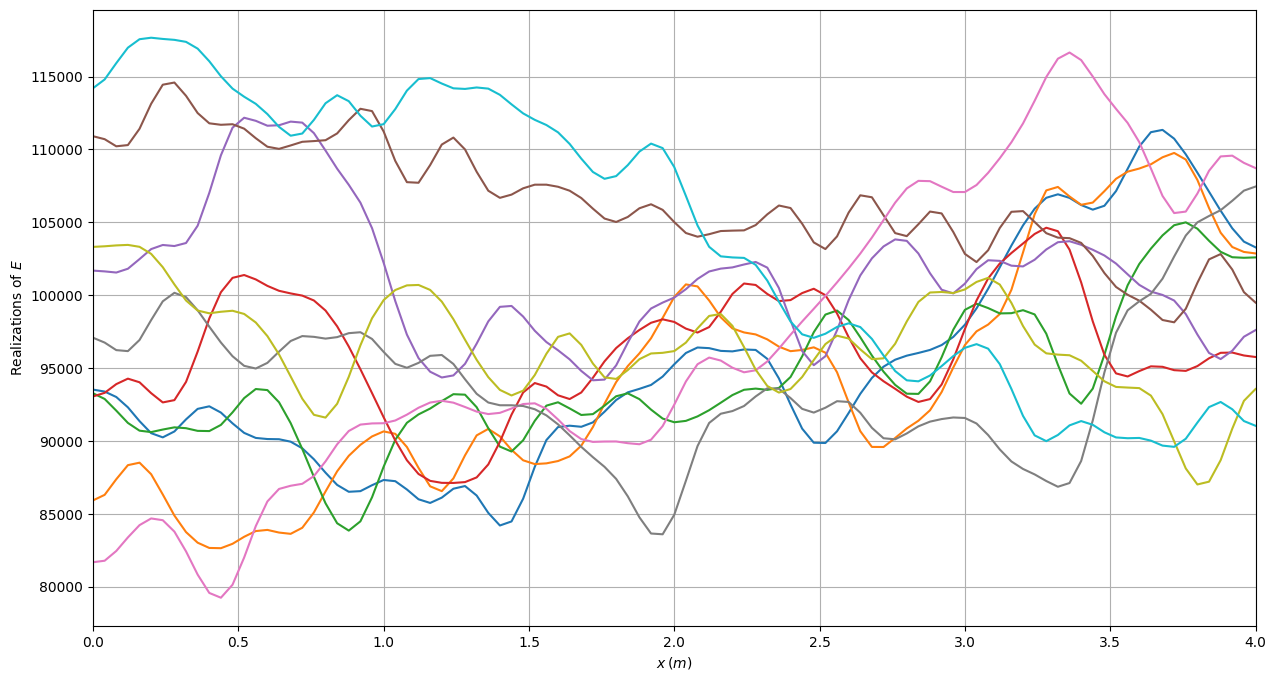

In [17]:
# Now let's see how some realizations looks like
no_of_realizations = 10
x = np.linspace(domain[0], domain[1], 101)

fig, ax = plt.subplots()
ax.set_xlabel(r"$x \: (m)$")
ax.set_ylabel(r"Realizations of $E$")
ax.grid(True)
fig.set_size_inches(15, 8)
ax.set_xlim(domain[0], domain[1])

for i in range(no_of_realizations):
    cosine_random_variables_set = np.random.normal(0, 1, size=len(cosine_frequency_array))
    sine_random_variables_set = np.random.normal(0, 1, size=len(sine_frequency_array))
    
    realization = np.array(
        [
            young_modulus_realization(
                cosine_frequency_array,
                cosine_eigen_values,
                cosine_constants,
                cosine_random_variables_set,
                sine_frequency_array,
                sine_eigen_values,
                sine_constants,
                sine_random_variables_set,
                domain,
                evaluation_point,
            )
            for evaluation_point in x
        ]
    )
    ax.plot(x, realization)

plt.show()

In [14]:
# Verification that the above implementation indeed represents the young's modulus
no_of_realizations = 5000
x = np.linspace(domain[0], domain[1], 101)
realization_collection = np.zeros((no_of_realizations, len(x)))

for i in range(no_of_realizations):
    cosine_random_variables_set = np.random.normal(0, 1, size=len(cosine_frequency_array))
    sine_random_variables_set = np.random.normal(0, 1, size=len(sine_frequency_array))

    realization = np.array(
        [
            young_modulus_realization(
                cosine_frequency_array,
                cosine_eigen_values,
                cosine_constants,
                cosine_random_variables_set,
                sine_frequency_array,
                sine_eigen_values,
                sine_constants,
                sine_random_variables_set,
                domain,
                evaluation_point,
            )
            for evaluation_point in x
        ]
    )

    realization_collection[i:] = realization

ensemble_mean_with_realization = np.zeros(realization_collection.shape[0])
ensemble_var_with_realization = np.zeros(realization_collection.shape[0])
for i in range(realization_collection.shape[0]):
    ensemble_mean_with_realization[i] = np.mean(realization_collection[:i+1, :])
    ensemble_var_with_realization[i] = np.var(realization_collection[:i+1, :])

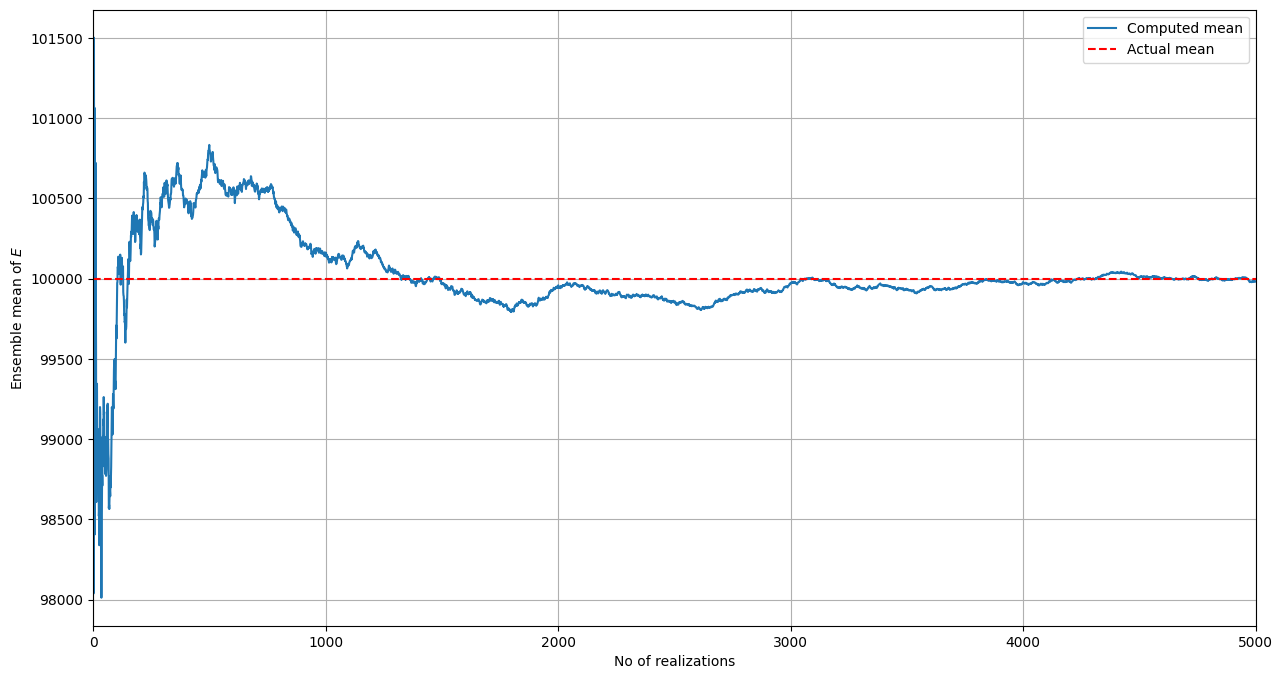

In [20]:
# Plot of ensemble mean
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
ax.plot(ensemble_mean_with_realization, label='Computed mean')
ax.axhline(y=1e5, color='r', linestyle='dashed', label='Actual mean')
plt.xlabel("No of realizations")
plt.ylabel(r"Ensemble mean of $E$")
ax.grid(True)
ax.set_xlim(0, no_of_realizations)
ax.legend()
plt.show()

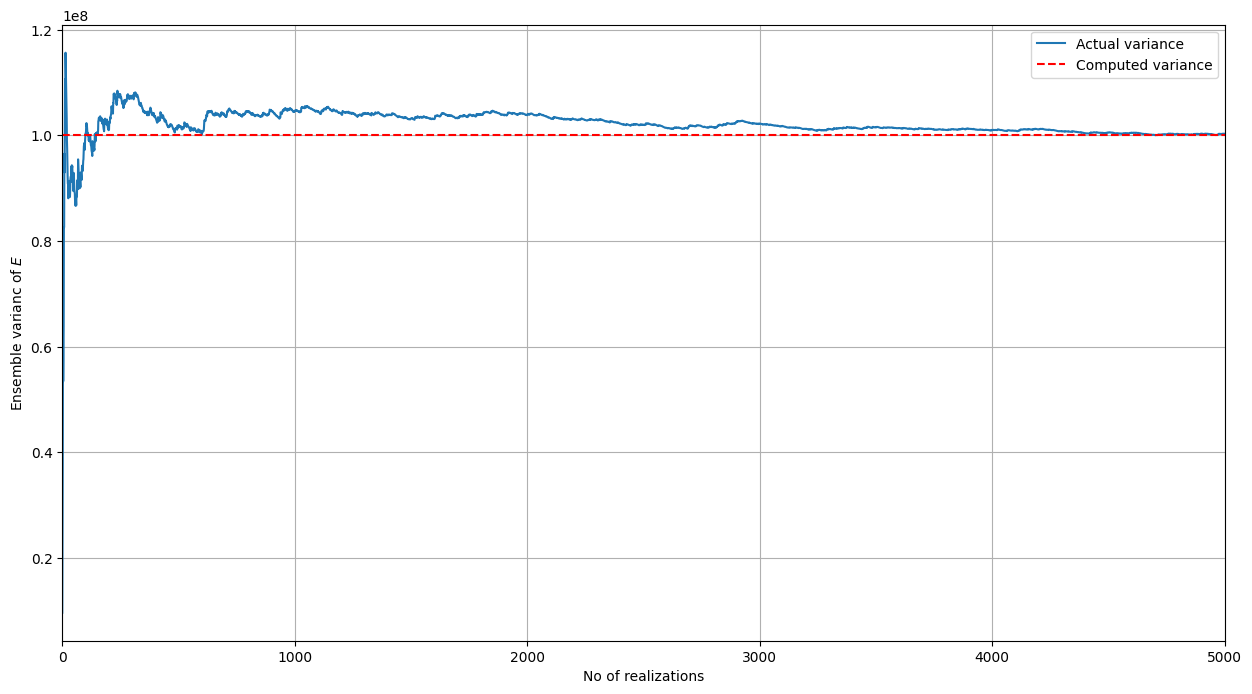

In [21]:
# Plot of ensemble variance
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
ax.plot(ensemble_var_with_realization, label='Actual variance')
ax.axhline(y=1e8, color='r', linestyle='dashed', label='Computed variance')
plt.xlabel("No of realizations")
plt.ylabel(r"Ensemble varianc of $E$")
ax.grid(True)
ax.set_xlim(0, no_of_realizations)
ax.legend()
plt.show()